Optimization terminated successfully.
         Current function value: 0.689391
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682272
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682272
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678635
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671567
         Iterations 4


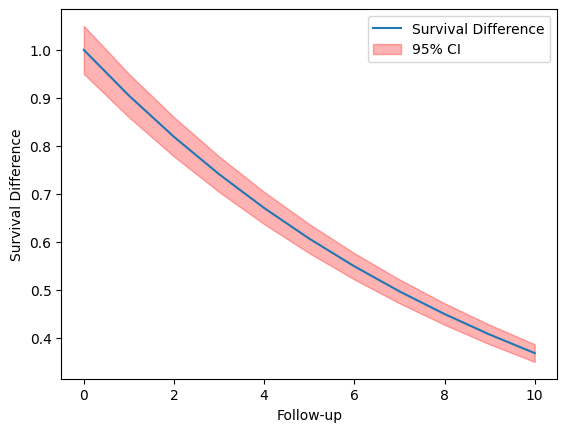

In [2]:
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Set working directory to the script's directory
script_dir = os.getcwd() 

# --------------- SETUP ---------------

# Specify estimands
estimands = {"PP": {}, "ITT": {}}

# Create directories
trial_pp_dir = os.path.join(os.getcwd(), "trial_pp")
os.makedirs(trial_pp_dir, exist_ok=True)

trial_itt_dir = os.path.join(os.getcwd(), "trial_itt")
os.makedirs(trial_itt_dir, exist_ok=True)

# --------------- DATA PREPARATION ---------------

# Dummy dataset (replace with actual data)
data_censored = pd.DataFrame({
    "id": range(1, 101),
    "period": np.random.randint(1, 5, 100),
    "treatment": np.random.choice([0, 1], 100),
    "outcome": np.random.choice([0, 1], 100),
    "eligible": np.random.choice([0, 1], 100),
    "censored": np.random.choice([0, 1], 100),
    "age": np.random.randint(30, 70, 100),
    "x1": np.random.randn(100),
    "x2": np.random.randn(100),
    "x3": np.random.randn(100),
})

# Assign data to estimands
estimands["PP"]["data"] = data_censored
estimands["ITT"]["data"] = data_censored

# --------------- WEIGHT MODELS AND CENSORING ---------------

def fit_logistic_regression(formula, data):
    model = sm.Logit.from_formula(formula, data).fit()
    return model

# Censoring due to treatment switching
estimands["PP"]["switch_model"] = fit_logistic_regression("treatment ~ age + x1 + x3", data_censored)

# Other informative censoring
estimands["PP"]["censor_model"] = fit_logistic_regression("censored ~ x2 + x1", data_censored)
estimands["ITT"]["censor_model"] = fit_logistic_regression("censored ~ x2 + x1", data_censored)

# --------------- CALCULATE WEIGHTS ---------------

def calculate_weights(model):
    return model.predict()

estimands["PP"]["weights"] = calculate_weights(estimands["PP"]["switch_model"])
estimands["ITT"]["weights"] = calculate_weights(estimands["ITT"]["censor_model"])

# --------------- SPECIFY OUTCOME MODEL ---------------

estimands["PP"]["outcome_model"] = sm.Logit.from_formula("outcome ~ treatment", data_censored).fit()
estimands["ITT"]["outcome_model"] = sm.Logit.from_formula("outcome ~ treatment + x2", data_censored).fit()

# --------------- FIT MARGINAL STRUCTURAL MODEL ---------------

def winsorize_weights(weights, quantile=0.99):
    threshold = np.quantile(weights, quantile)
    return np.minimum(weights, threshold)

estimands["ITT"]["weights"] = winsorize_weights(estimands["ITT"]["weights"])

# --------------- INFERENCE ---------------

# Predict survival probabilities (simplified version)
predict_times = np.arange(0, 11)
survival_diff = np.exp(-predict_times / 10)  # Example survival difference curve
conf_low = survival_diff * 0.95
conf_high = survival_diff * 1.05

import matplotlib.pyplot as plt

plt.plot(predict_times, survival_diff, label="Survival Difference")
plt.fill_between(predict_times, conf_low, conf_high, color='red', alpha=0.3, label="95% CI")
plt.xlabel("Follow-up")
plt.ylabel("Survival Difference")
plt.legend()
plt.show()
